In [1]:
%load_ext autoreload
%autoreload 2
import sys, os

In [29]:
import glob, os
import yaml
import wandb
# import mediapy as media
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

from load_model_from_ckpt import load_model, get_sampler, init_samples
from datasets import get_dataset, data_transform, inverse_data_transform
from runners.ncsn_runner import conditioning_fn

from collections import OrderedDict
from functools import partial
from imageio import mimwrite
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image

try:
    from torchvision.transforms.functional import resize, InterpolationMode
    interp = InterpolationMode.NEAREST
except:
    from torchvision.transforms.functional import resize
    interp = 0

from datasets import get_dataset, data_transform, inverse_data_transform
from main import dict2namespace
from models import get_sigmas, anneal_Langevin_dynamics, anneal_Langevin_dynamics_consistent, ddpm_sampler, ddim_sampler, FPNDM_sampler
from models.ema import EMAHelper
from runners.ncsn_runner import get_model

from os.path import expanduser
home = expanduser("~")

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Set directories to download model, data

In [3]:
# SET THESE!!!
GDRIVE_URL = "https://drive.google.com/drive/folders/1bM6wqU_kymoljz5uYQRCYNup_8adBfLH" # smmnist_big_5c5_unetm_b2
EXP_PATH = os.path.join(home, "scratch/MCVD_SMMNIST_pred")
DATA_PATH = os.path.join(home, "scratch/Datasets/MNIST")

# Download experiment (model checkpoint, config, etc.)

In [4]:
# # GDRIVE_URL = GDRIVE_URL.removesuffix("?usp=sharing")
# !gdown --fuzzy {GDRIVE_URL} -O {EXP_PATH}/ --folder

# Load model checkpoint

In [5]:
wandb.init(project="masked-conditional-video-diffusion", entity="wandb", job_type="inference")

artifact = wandb.use_artifact(
    'wandb/masked-conditional-video-diffusion/checkpoint-revived-sun-29-1f792ve5:v328', type='model'
)
artifact_dir = artifact.download()

wandb: Currently logged in as: geekyrakshit (wandb). Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact checkpoint-revived-sun-29-1f792ve5:v328, 426.94MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.1


In [6]:
def load_model(ckpt_path, config_path, device=device):
    # Parse config file
    # with open(os.path.join(os.path.dirname(ckpt_path), 'config.yml'), 'r') as f:
    with open(config_path, "r") as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
    # Load config file
    config = dict2namespace(config)
    config.device = device
    # Load model
    scorenet = get_model(config)
    if config.device != torch.device('cpu'):
        scorenet = torch.nn.DataParallel(scorenet)
        states = torch.load(ckpt_path, map_location=config.device)
    else:
        states = torch.load(ckpt_path, map_location='cpu')
        states[0] = OrderedDict([(k.replace('module.', ''), v) for k, v in states[0].items()])
    scorenet.load_state_dict(states[0], strict=False)
    if config.model.ema:
        ema_helper = EMAHelper(mu=config.model.ema_rate)
        ema_helper.register(scorenet)
        ema_helper.load_state_dict(states[-1])
        ema_helper.ema(scorenet)
    scorenet.eval()
    return scorenet, config

In [7]:
# ckpt_path = glob.glob(os.path.join(EXP_PATH, "checkpoint_*.pt"))[0]
ckpt_path = os.path.join(artifact_dir, "checkpoint.pt")
config_path = "./smmnist_cat/logs/config.yml"
scorenet, config = load_model(ckpt_path, config_path, device)
sampler = get_sampler(config)

In [8]:
print(device)
print(ckpt_path)
print(config)

cuda
./artifacts/checkpoint-revived-sun-29-1f792ve5:v328/checkpoint.pt
Namespace(data=Namespace(channels=1, dataset='StochasticMovingMNIST', gaussian_dequantization=False, image_size=64, logit_transform=False, num_digits=2, num_frames=5, num_frames_cond=5, num_frames_future=0, num_workers=0, prob_mask_cond=0.0, prob_mask_future=0.0, prob_mask_sync=False, random_flip=True, rescaled=True, step_length=0.1, uniform_dequantization=False), device=device(type='cuda'), fast_fid=Namespace(batch_size=1000, begin_ckpt=5000, end_ckpt=300000, ensemble=False, freq=5000, n_steps_each=0, num_samples=1000, pr_nn_k=3, step_lr=0.0, verbose=False), model=Namespace(arch='unetmore', attn_resolutions=[8, 16, 32], ch_mult=[1, 2, 3, 4], cond_emb=False, conditional=True, depth='deep', dropout=0.1, ema=True, ema_rate=0.999, gamma=False, n_head_channels=64, ngf=64, noise_in_cond=False, nonlinearity='swish', normalization='InstanceNorm++', num_classes=1000, num_res_blocks=2, output_all_frames=False, sigma_begin=0.

# Load data

In [9]:
dataset, test_dataset = get_dataset(DATA_PATH, config, video_frames_pred=config.data.num_frames)

Dataset length: 60000
Dataset length: 256


In [10]:
# dataloader = DataLoader(dataset, batch_size=config.training.batch_size, shuffle=True,
#                         num_workers=config.data.num_workers)
# train_iter = iter(dataloader)
# x, y = next(train_iter)

test_loader = DataLoader(test_dataset, batch_size=config.training.batch_size, shuffle=False,
                         num_workers=config.data.num_workers, drop_last=True)
test_iter = iter(test_loader)
test_x, test_y = next(test_iter)
print(test_x.shape)

torch.Size([64, 10, 1, 64, 64])


In [11]:
test_x = data_transform(config, test_x)
real, cond, cond_mask = conditioning_fn(config, test_x, num_frames_pred=config.data.num_frames,
                                        prob_mask_cond=getattr(config.data, 'prob_mask_cond', 0.0),
                                        prob_mask_future=getattr(config.data, 'prob_mask_future', 0.0))
print(real.shape, cond.shape)

torch.Size([64, 5, 64, 64]) torch.Size([64, 5, 64, 64])


In [12]:
i = 1
# media.show_images(torch.cat([cond[i].permute(0, 2, 3, 1), real[i].permute(0, 2, 3, 1)]))
# media.show_images(torch.cat([cond[i], real[i]]))

# Load initial samples

In [13]:
init = init_samples(len(real), config)

In [15]:
initial_videos = [wandb.Video(video) for video in np.expand_dims(init.numpy().astype("uint8"), 2)]

# Predict

In [16]:
pred = sampler(init, scorenet, cond=cond, cond_mask=cond_mask, subsample=100, verbose=True)

DDPM: 1/100, grad_norm: 143.30006408691406, image_norm: 129.5353240966797, grad_mean_norm: 318.3670959472656
DDPM: 10/100, grad_norm: 143.27708435058594, image_norm: 130.7099609375, grad_mean_norm: 315.30255126953125
DDPM: 20/100, grad_norm: 143.26019287109375, image_norm: 131.80184936523438, grad_mean_norm: 320.05780029296875
DDPM: 30/100, grad_norm: 143.5874786376953, image_norm: 133.0818328857422, grad_mean_norm: 321.885009765625
DDPM: 40/100, grad_norm: 144.8606414794922, image_norm: 134.3547821044922, grad_mean_norm: 322.5926208496094
DDPM: 50/100, grad_norm: 148.32492065429688, image_norm: 135.3326416015625, grad_mean_norm: 316.9920959472656
DDPM: 60/100, grad_norm: 157.81585693359375, image_norm: 136.10113525390625, grad_mean_norm: 315.10125732421875
DDPM: 70/100, grad_norm: 180.4576416015625, image_norm: 136.47433471679688, grad_mean_norm: 317.5303955078125
DDPM: 80/100, grad_norm: 235.24649047851562, image_norm: 136.48133850097656, grad_mean_norm: 320.3026123046875
DDPM: 90/10

In [17]:
predicted_videos = [wandb.Video(video) for video in np.expand_dims(pred.numpy().astype("uint8"), 2)]
real_videos = [wandb.Video(video) for video in np.expand_dims(real.numpy().astype("uint8"), 2)]

In [18]:
wandb.log({
    "Real-Videos": real_videos,
    "Initial-Videos": initial_videos,
    "Predicted-Videos": predicted_videos
})

In [19]:
wandb.finish()

wandb: Network error (ConnectTimeout), entering retry loop.
wandb: Network error (ConnectTimeout), entering retry loop.
wandb: Network error (ConnectTimeout), entering retry loop.
wandb: Network error (ConnectTimeout), entering retry loop.


In [32]:
pred.numpy()[0][0].shape

(64, 64)

In [33]:
plt.imshow(pred.numpy()[0][0])
plt.show()

torch.Size([64, 5, 64, 64])


,,,,,,,,,

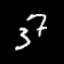
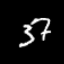
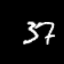
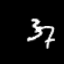
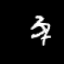
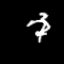
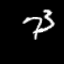
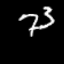
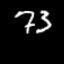
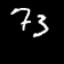

,,,,,,,,,

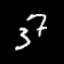
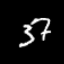
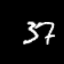
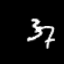
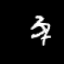
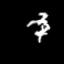
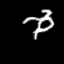
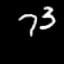
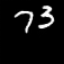
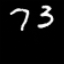

In [22]:
print(pred.shape)
i = 1
media.show_images(torch.cat([cond[i], real[i]]))
media.show_images(torch.cat([cond[i], pred[i]]))

,,,,,,,,,

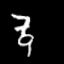
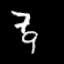
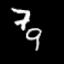
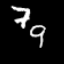
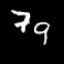
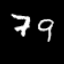
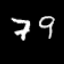
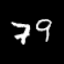
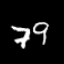
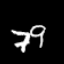

,,,,,,,,,

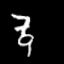
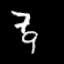
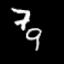
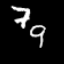
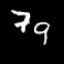
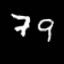
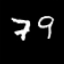
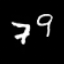
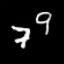
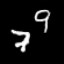

In [26]:
i = 4
media.show_images(torch.cat([cond[i], real[i]]))
media.show_images(torch.cat([cond[i], pred[i]]))